# Diffusion Inference

In [1]:
from diffusion import testing, plt, os, pickle, parse, np


In [ ]:
os.makedirs('inference/',exist_ok=True)
for ckpt_path in os.listdir('pretrained/'):
    result = parse('{}_arch{}_e{}_d{}_edim{}_ks{}_par{}_date{}', ckpt_path)
    system_name, num_epochs = result[0], result[2]

    model_path = f'pretrained/{ckpt_path}/model_ema_{system_name}_{int(num_epochs)-1}.ckpt'
    if os.path.exists(model_path):
        if not os.path.exists(f'inference/{ckpt_path}/data.pkl'):
            print(ckpt_path)
            data, trajectories, ended_correctly = testing(model_path, max_steps=400, n_sim=200)
            os.makedirs(f'inference/{ckpt_path}',exist_ok=True)
            with open(f'inference/{ckpt_path}/data.pkl', 'wb') as handle:
                pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

            with open(f'inference/{ckpt_path}/trajectories.pkl', 'wb') as handle:
                pickle.dump(trajectories, handle, protocol=pickle.HIGHEST_PROTOCOL)


[Dataset] Loading Dataset 2d from memory
[2d][@carlo change] Obs: x, x_dot, y, y_dot
[@carlo change] Action: x_acc, y_ acc (?)
Observation Dim:  4 Action Dim:  2
number of parameters: 3.700482e+06
Pretrained weights loaded.


Eval:   0%|          | 0/400 [00:00<?, ?it/s]

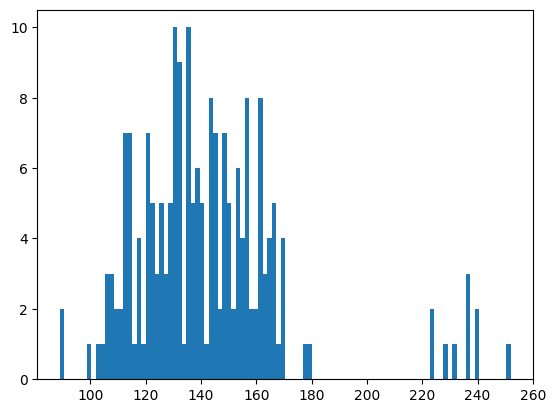

In [34]:

data, trajectories, ended_correctly = testing('pretrained/2d_arch256_e100_d50_edim256_ks5_par3_70e06_date04_26_02_05_22/model_ema_2d_99.ckpt', max_steps=400, n_sim=1)

f = open(f'inference/2d_arch256_e100_d50_edim256_ks5_par3_70e06_date04_26_02_05_22/data.pkl', 'rb')
data2 = pickle.load(f) # REWARD, TRAJECTORIES
f.close()

# (True, reward, speed, max(rewards), step_idx), (OBS, ACTION_PRED)
data.shape, trajectories.__len__()

freq, thres, _ = plt.hist(data2[:,-1], bins = 100);

# Validation sets

3d 3d 3d 3d 3d 3d 3d 3d 3d 3d 

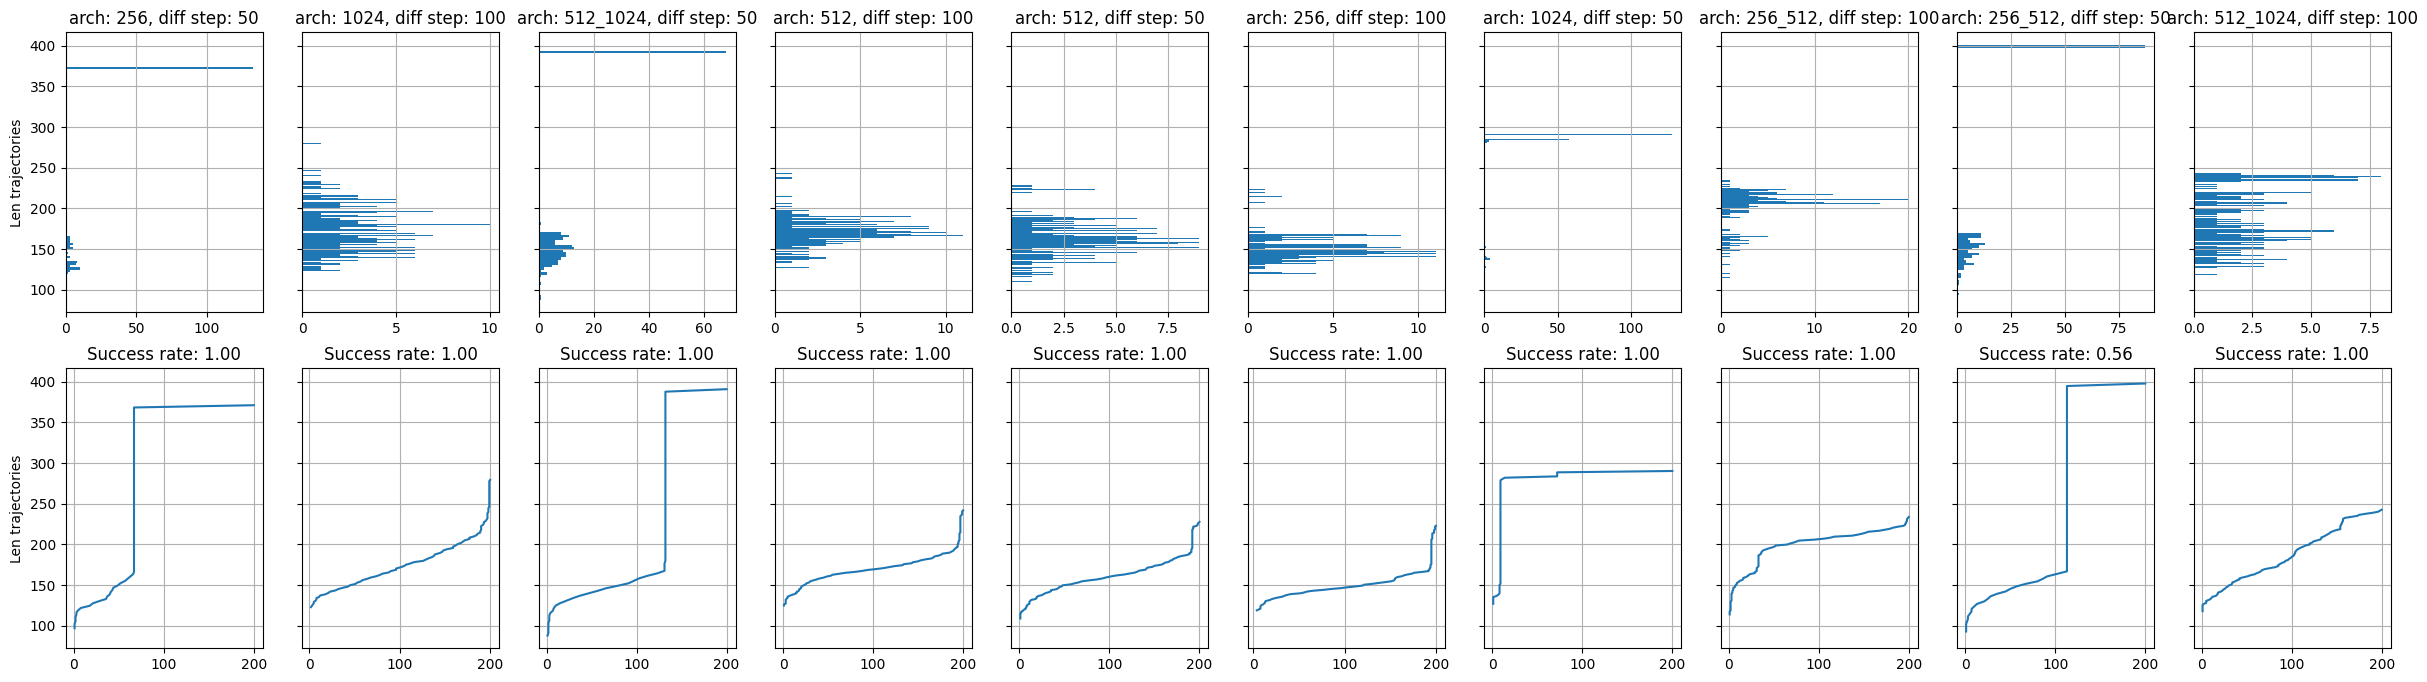

In [23]:
fig, (axs1, axs2) = plt.subplots(2, 10, figsize = (30, 8), sharey=True)
list_3d = [i for i in os.listdir('inference/') if '3d' in i]

for ckpt_path, ax1, ax2 in zip(list_3d, axs1, axs2):

    result = parse('{}_arch{}_e{}_d{}_edim{}_ks{}_par{}_date{}', ckpt_path)
    system_name, arch, diff = result[0], result[1], result[3]
    print(system_name, end = ' ')
    f = open(f'inference/{ckpt_path}/data.pkl', 'rb')
    data = pickle.load(f) # REWARD, TRAJECTORIES
    f.close()

    freq, thres, _ = ax1.hist(data[:,-1], bins = 100, orientation='horizontal');


    ax1.set_title(f'arch: {arch}, diff step: {diff}')
    ax1.grid()


    ax2.set_title(f'Success rate: {np.sum(data[:, 0])/data[:,0].shape[0]:.2f}')
    ax2.plot(np.cumsum(freq), thres[:-1]);
    ax2.grid()

axs1[0].set_ylabel('Len trajectories')
axs2[0].set_ylabel('Len trajectories')

# plt.savefig('validation_3d.pdf', bbox_inches = 'tight', pad_inches = 0)


# One trajectory

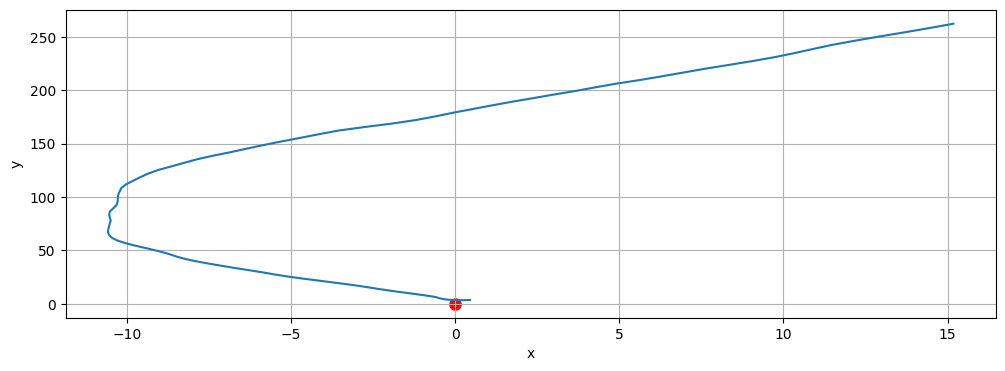

In [29]:
import numpy as np
import matplotlib.pyplot as plt
OBS = np.array(trajectories[0][0]) #obs

# print(OBS.shape)
T_end = 100
fig, ax1 = plt.subplots(1,1, figsize = (12,4))
ax1.plot(OBS[:T_end,0], OBS[:T_end,2]); ax1.scatter(0,0, color= 'r', linewidth=3,);
ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.grid()

plt.show()

---
# No need to run from now on - Plot Generator 2D


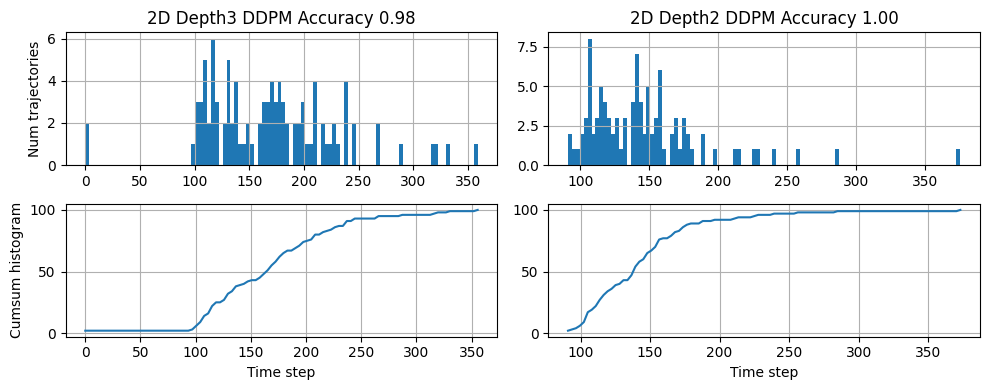

In [30]:
f = open('datasets/inference_2D_depth3.pkl', 'rb')
test_2d = pickle.load(f)
f.close()

f = open('datasets/inference_2D_depth2.pkl', 'rb')
test_2d_small = pickle.load(f)
f.close()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 4));

freq, thres, _ = ax1.hist(test_2d[:,2], bins = 100);

ax1.set_ylabel('Num trajectories');
ax1.set_title(f'2D Depth3 DDPM Accuracy {sum(test_2d[:,0] > 0.5)/100.:.2f}')

ax3.plot(thres[:-1], np.cumsum(freq));
ax2.set_title(f'2D Depth2 DDPM Accuracy {sum(test_2d_small[:,0] > 0.5)/100.:.2f}')

freq, thres, _ = ax2.hist(test_2d_small[:,2], bins = 100);
ax4.plot(thres[:-1], np.cumsum(freq));

ax3.set_ylabel('Cumsum histogram');
ax3.set_xlabel('Time step');
ax4.set_xlabel('Time step');


ax1.grid(); ax2.grid();
ax3.grid(); ax4.grid();

plt.tight_layout()
# plt.savefig('2D_bins.pdf', bbox_inches = 'tight', pad_inches = 0)


# Plot 3D Trajectory

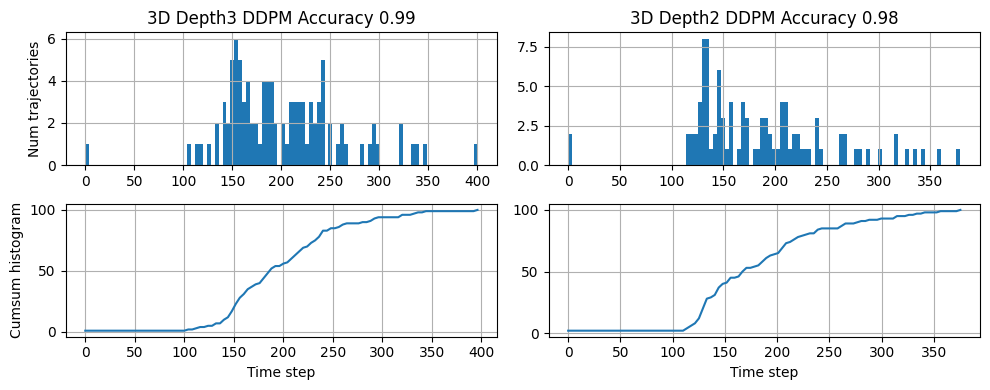

In [32]:
f = open('datasets/inference_3D_depth3.pkl', 'rb')
test_2d = pickle.load(f)
f.close()

f = open('datasets/inference_3D_depth2.pkl', 'rb')
test_2d_small = pickle.load(f)
f.close()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 4));

freq, thres, _ = ax1.hist(test_2d[:,2], bins = 100);

ax1.set_ylabel('Num trajectories');
ax1.set_title(f'3D Depth3 DDPM Accuracy {sum(test_2d[:,0] > 0.5)/100.:.2f}')

ax3.plot(thres[:-1], np.cumsum(freq));
ax2.set_title(f'3D Depth2 DDPM Accuracy {sum(test_2d_small[:,0] > 0.5)/100.:.2f}')

freq, thres, _ = ax2.hist(test_2d_small[:,2], bins = 100);
ax4.plot(thres[:-1], np.cumsum(freq));

ax3.set_ylabel('Cumsum histogram');
ax3.set_xlabel('Time step');
ax4.set_xlabel('Time step');


ax1.grid(); ax2.grid();
ax3.grid(); ax4.grid();

plt.tight_layout()
plt.savefig('3D_bins.pdf', bbox_inches = 'tight', pad_inches = 0)


---
# Further Visualizations

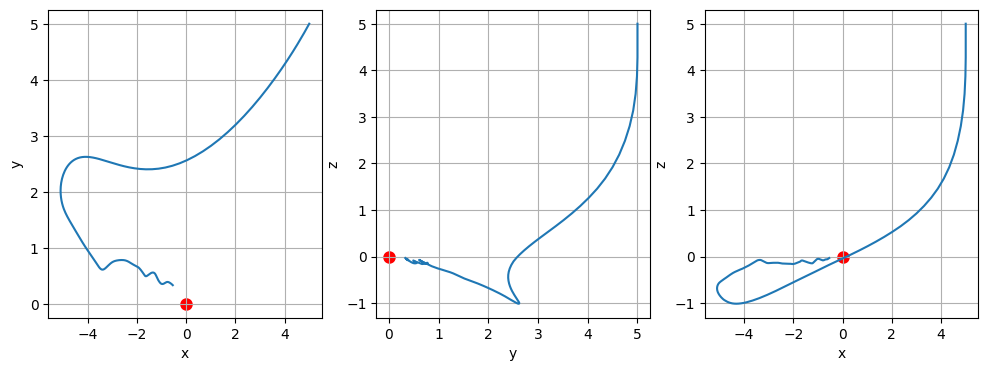

[-0.54293202  0.33101718 -0.02896317  0.11252511 -0.04216489  0.03295834
 -0.00367185  0.00484187 -0.02238284 -0.01354116  0.0180512   0.00996688]


In [41]:
import matplotlib.patches as patches

OBS = np.array(OBS)
# 3D PLOT
# ax = plt.figure().add_subplot(projection='3d') #figsize = (10,10)
# ax.plot(OBS[:,0], OBS[:,2], OBS[:,4]); ax.grid()
# ax.scatter(0,0,0,color= 'r', linewidth=3,);

# # 2D Projection 3D Plot
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))
# ax1.plot(OBS[:,0], OBS[:,2]); ax1.scatter(0,0, color= 'r', linewidth=3,);
# ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.grid()
# ax2.plot(OBS[:,2], OBS[:,4]); ax2.scatter(0,0, color= 'r', linewidth=3,);
# ax2.set_xlabel('y'); ax2.set_ylabel('z'); ax2.grid()
# ax3.plot(OBS[:,0], OBS[:,4]); ax3.scatter(0,0, color= 'r', linewidth=3,);
# ax3.set_xlabel('x'); ax3.set_ylabel('z'); ax3.grid()


# 2D Projection 3D Plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))
ax1.plot(OBS[:,0], OBS[:,1]); ax1.scatter(0,0, color= 'r', linewidth=3,);
ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.grid()
ax2.plot(OBS[:,1], OBS[:,2]); ax2.scatter(0,0, color= 'r', linewidth=3,);
ax2.set_xlabel('y'); ax2.set_ylabel('z'); ax2.grid()
ax3.plot(OBS[:,0], OBS[:,2]); ax3.scatter(0,0, color= 'r', linewidth=3,);
ax3.set_xlabel('x'); ax3.set_ylabel('z'); ax3.grid()



plt.show()
# ax2.plot(OBS[:,1]); ax2.grid()
# ax3.plot(OBS[:,3]); ax3.grid()
# rect = patches.Rectangle((-0.1, -0.1), 0.2, 0.2, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
# ax1.add_patch(rect)
print(OBS[-1])

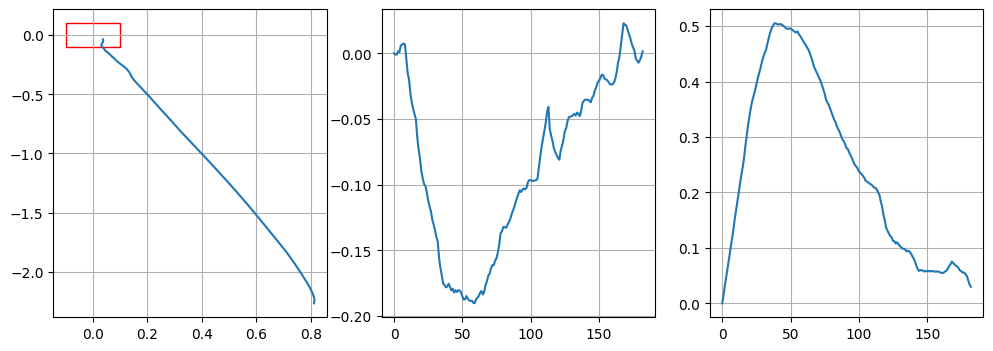

In [16]:
import matplotlib.patches as patches

OBS = np.array(OBS)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))

ax1.plot(OBS[:,0], OBS[:,2]); ax1.grid()
ax2.plot(OBS[:,1]); ax2.grid()
ax3.plot(OBS[:,3]); ax3.grid()
rect = patches.Rectangle((-0.1, -0.1), 0.2, 0.2, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax1.add_patch(rect)


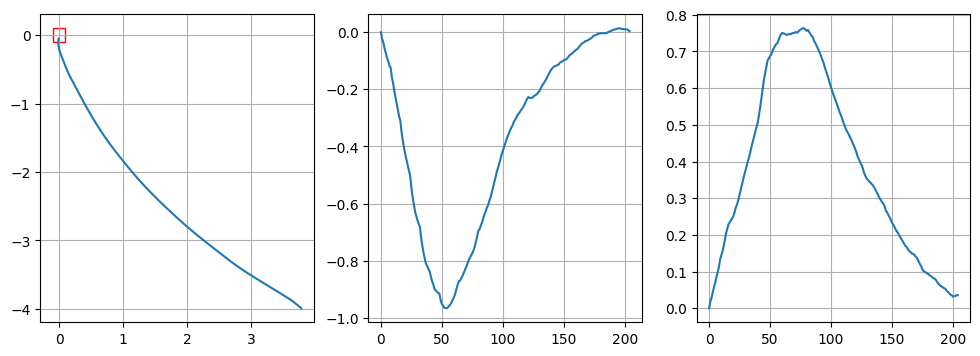

In [62]:
import matplotlib.patches as patches

OBS = np.array(OBS)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))

ax1.plot(OBS[:,0], OBS[:,2]); ax1.grid()
ax2.plot(OBS[:,1]); ax2.grid()
ax3.plot(OBS[:,3]); ax3.grid()
rect = patches.Rectangle((-0.1, -0.1), 0.2, 0.2, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax1.add_patch(rect)
